> *Comments and notes throughout the notebook are purposely made for personal reasons, to deeper understand the topics discussed both in ML and Robotics I. They are not meant in any way to serve as a substitute for the final report of the homework, and they most likely contain mistakes.*
>
> **All of the code used for plotting involving `matplotlib` is AI-generated.**

# Forward Kinematics
---
The task (**regression**) is to learn the forward kinematics for each robot model.
- Input: Joint angles
- Output: End-effector pose

In [101]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from scipy.spatial.transform import Rotation as R # Quaternion -> Euler angles
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras import layers, models

from envs.reacher_v6 import ReacherEnv
from envs.reacher3_v6 import Reacher3Env
from envs.marrtino_arm import MARRtinoArmEnv

print('Libraries imported.')

seed = 1891909

Libraries imported.


## Planar 2R robotic arm
First, let us conduct the analysis on the robot model with $n=2$ revolute joints in the $2$D space.
- **Input**: $\mathbf{q}=\begin{bmatrix} q_1 & q_2 \end{bmatrix}^T$
- **Output**: $\mathbf{r}_e = \begin{bmatrix} \mathbf{p}_e & \boldsymbol{\phi}_e \end{bmatrix}^T$

### Generation of the dataset
To learn forward kinematics of the $3$ robot models, it is first needed to collect data from some simulated actions. To this extent, the `collect_data` function observe the results of `num_steps` randomly sampled actions and returns as a NumPy array the examples to build the dataset.

The boolean parameter `debug` permits going through the simulation and show the collected examples at each iteration.

When `ndim == 2` we can exract the information about the orientation of the end-effector from $\mathbf{q}_e$ (quaternion) by computing
$$ \vartheta_e = 2\text{atan2}(\text{qz}_e, \text{qw}_e) $$
where we used $\text{atan2}$ to compute the $4$-quadrant arctangent, which accounts for the signs of both input arguments to determine the correct quadrant.

When `ndim == 3`, we just represent the orientation with Euler angles.

In [102]:
def collect_data(env, num_steps=100000, debug=False):
    #print('\nCollecting data ...')
    data = []
    observation, _ = env.reset(seed=1891909)
    env.action_space.seed(seed=1891909)
    if (debug):
        print('\n########## DEBUG MODE ##########')
        print('Press CTRL+C to quit')
        print(f'Number of joints/DOFs (n): {env.njoints}')
        print(f'Dimension of the task space (m): {env.ndim}')
        print('\nDisplaying collected examples one by one ...')
    for i in range(1, num_steps+1):
        # Sample an action and simulate it
        action = env.action_space.sample()
        observation, _, terminated, truncated, _ = env.step(action)

        # Collect the data
        joint_angles = observation[:env.njoints]
        if env.ndim == 2: # the last 2 are target_x, target_y
            ee_position = observation[-6:-4]      # [x, y]
            qw, qz = observation[-4:-2]           # [qw, qz]
            theta = 2*np.arctan2(qz, qw)          # theta
            #ee_pose = observation[-6:-2]         # [x, y, qw, qz]
            ee_pose = np.concatenate([ee_position, [theta]])   # [x, y, theta]
        elif env.ndim == 3: # the last 3 are target_xyz
            ee_position = observation[-10:-7]     # [x, y, z]
            qw, qx, qy, qz = observation[-7:-3]    # [qw, qx, qy, qz]
            r = R.from_quat([qx, qy, qz, qw])
            yaw, pitch, roll = r.as_euler('zyx', degrees=False)
            #ee_pose = observation[-10:-3]
            ee_pose = np.concatenate([ee_position, [yaw, pitch, roll]]) # [x, y, z, yaw, pitch, roll]
        data.append(np.concatenate((joint_angles, ee_pose)))
        
        # Termination condition
        if terminated or truncated:
            env.reset()

        if i % (num_steps/10) == 0:
            print(f'Collected {i}/{num_steps} examples')

        if (debug):
            print(f'\nExample {i}')
            print(f'Joint angles: (q1, q2) = ({joint_angles[0]:.3f}, {joint_angles[1]:.3f})')
            if env.ndim == 2:
                print(f'End-effector pose: (x_e, y_e, theta) = ({ee_pose[0]:.3f}, {ee_pose[1]:.3f}, {ee_pose[2]:.3f})')
            elif env.ndim == 3:
                print(f'End-effector pose: (x_e, y_e, z_e, yaw, pitch, roll) = ({ee_pose[0]:.3f}, {ee_pose[1]:.3f}, {ee_pose[2]:.3f}, {ee_pose[3]:.3f}, {ee_pose[4]:.3f}, {ee_pose[5]:.3f})')
            input('Press whatever to show the next example ...')

    return np.array(data)

#### Load data

To effectively load the collected data, we can employ the simple `load_data` function.

In [103]:
def load_data(env_name, nsamples):
    if env_name == 'r2':
        env = ReacherEnv(render_mode=None)
    elif env_name == 'r3':
        env = Reacher3Env(render_mode=None)
    elif env_name == 'r5':
        env = MARRtinoArmEnv(render_mode=None)
    
    print(f'Loading data ({nsamples} samples) for {env_name} ...')
    data = collect_data(env, num_steps=nsamples)
    print('Data loaded succesfully!')

    print('\nTask: Regression (learn Forward Kinematics)')
    print('Input: Joint angles')
    print('Target: EE pose')
    if env_name == 'r2':   # 2 Joints, 2D space (planar 2R)
        X_all, y_all = data[:, :2], data[:, 2:]
    elif env_name == 'r3': # 3 Joints, 2D space (planar 3R)
        X_all, y_all = data[:, :3], data[:, 3:]
    elif env_name == 'r5': # 5 Joints, 3D space (spatial 5R)
        X_all, y_all = data[:, :5], data[:, 5:]
    return X_all, y_all

In [78]:
# Load data
env = 'r2'
nsamples = 100000
X_all, y_all = load_data(env, nsamples=nsamples)

# Print loaded data info
ninput = X_all.shape[1]
nsamples = X_all.shape[0]
noutput = y_all.shape[1]
print(f'\nDataset: {env}')
print(f'Input shape: {X_all.shape}')
print(f'Output shape: {y_all.shape}')
print(f'Number of samples: {nsamples}')
print(f'Number of attributes/features: {ninput}')

Loading data (100000 samples) for r2 ...
Collected 10000/100000 examples
Collected 20000/100000 examples
Collected 30000/100000 examples
Collected 40000/100000 examples
Collected 50000/100000 examples
Collected 60000/100000 examples
Collected 70000/100000 examples
Collected 80000/100000 examples
Collected 90000/100000 examples
Collected 100000/100000 examples
Data loaded succesfully!

Task: Regression (learn Forward Kinematics)
Input: Joint angles
Target: EE pose

Dataset: r2
Input shape: (100000, 2)
Output shape: (100000, 3)
Number of samples: 100000
Number of attributes/features: 2


#### Preparing data for model training
Once collected and loaded the necessary data, we can split it into the training and test set. Displaying examples allows for a straightforward understanding of how the examples are made. For the `r2` robot, the input simply involves the two joint angles `j1` and `j2`, while the target represents the end-effector pose which is given by its **position** and **orientation**:
- the position consists of the coordinates in the plane of the end-effector, namely (`ee_x`, `ee_y`)
- the orientation of the end-effector is represented through a **quaternion**; in this case only `ee_qw` (the scalar part) and `ee_qz`, as `r2` operates in a $2$D space.

Edit: I converted quaternions to Euler angles.

In [53]:
# Split data
print('Splitting data ...')
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.333, random_state=1891909)
print(f'Training set size: {len(X_train)}')
print(f'Test set size: {len(X_test)}')

# Show some examples
print('\nDisplaying the first 5 examples ...')
for i in range(5):
    print(f'Example {i+1}')
    print(f'Joint angles (X): {X_all[i]}')
    print(f'End-Effector pose (Y): {y_all[i]}\n')

Splitting data ...
Training set size: 66700
Test set size: 33300

Displaying the first 5 examples ...
Example 1
Joint angles (X): [-0.00974605 -0.08422618]
End-Effector pose (Y): [ 0.20951003 -0.01129499 -0.09396109]

Example 2
Joint angles (X): [ 0.00094756 -0.12639879]
End-Effector pose (Y): [ 0.20913537 -0.01367038 -0.12546031]

Example 3
Joint angles (X): [ 0.05886377 -0.18566699]
End-Effector pose (Y): [ 0.20894367 -0.00802971 -0.12680674]

Example 4
Joint angles (X): [ 0.12810304 -0.26791244]
End-Effector pose (Y): [ 0.20810731 -0.00255197 -0.13980104]

Example 5
Joint angles (X): [ 0.18481556 -0.34540703]
End-Effector pose (Y): [ 0.2068816   0.00078646 -0.16059654]



### Train the model
To learn the forward kinematics of the 2R planar robot, we can employ a simple 3-layer neural network.

Training the model...
Epoch 1/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1962 - val_loss: 0.0260
Epoch 2/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0371 - val_loss: 0.0256
Epoch 3/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0366 - val_loss: 0.0255
Epoch 4/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0364 - val_loss: 0.0254
Epoch 5/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0363 - val_loss: 0.0253
Epoch 6/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0362 - val_loss: 0.0252
Epoch 7/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0362 - val_loss: 0.0252
Epoch 8/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0361 - val_loss: 0.0252
Epoch 9/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0361 - val_loss: 0.0252
Epoch 10/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0360 - val_loss: 0.0251
Epoch 11/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0359 - val_loss: 0.0251
Epoch 12

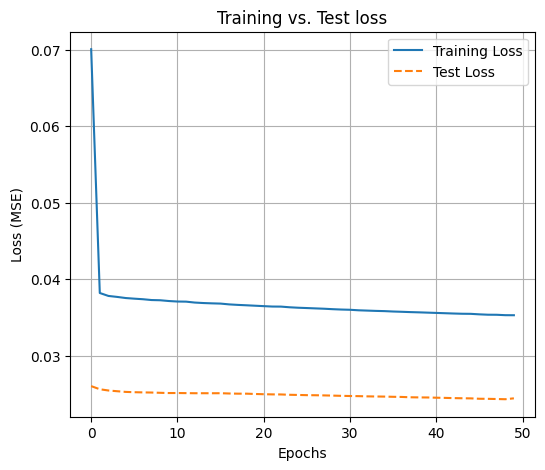

CPU times: user 7min 40s, sys: 1min 3s, total: 8min 44s
Wall time: 4min 34s


In [58]:
%%time

# Define optimizer and loss function
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

tf.keras.utils.set_random_seed(seed)

# Check if the model already exists to avoid training it over
if os.path.exists('fk_r2.keras'):
    model = tf.keras.models.load_model('fk_r2.keras')
    print("Model loaded!")
else:
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(ninput,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(noutput)
    ])
    model.compile(loss=loss_fn, optimizer=opt)
    print("Training the model...")
    nepochs = 50
    batch_size = 32
    h = model.fit(X_train, y_train, epochs=nepochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
    print(f"Final training loss: {h.history['loss'][-1]}")
    print(f'Final test loss: {h.history['val_loss'][-1]}')
    model.save('fk_r2.keras')

    plt.figure(figsize=(6, 5))
    plt.plot(h.history['loss'], label='Training Loss')
    plt.plot(h.history['val_loss'], label='Test Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training vs. Test loss')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Evaluation of the model
Here we use a test set to evaluate model predictions...

In [61]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error = {mae:.4f}')
print(f'R2-Score = {r2:.4f}')

1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Mean Absolute Error = 0.0128
R2-Score = 0.9918


##### Plotting results
It is noticeable how if the predicted data were used on an actual robot for its forward kinematics, this would sometimes lead to positions that are outside of the robot's workspace, and thus that are actually not reachable by the end-effector.

> Only `len(y)-30000` samples are considered for plotting for computation time reasons and clarity of results.

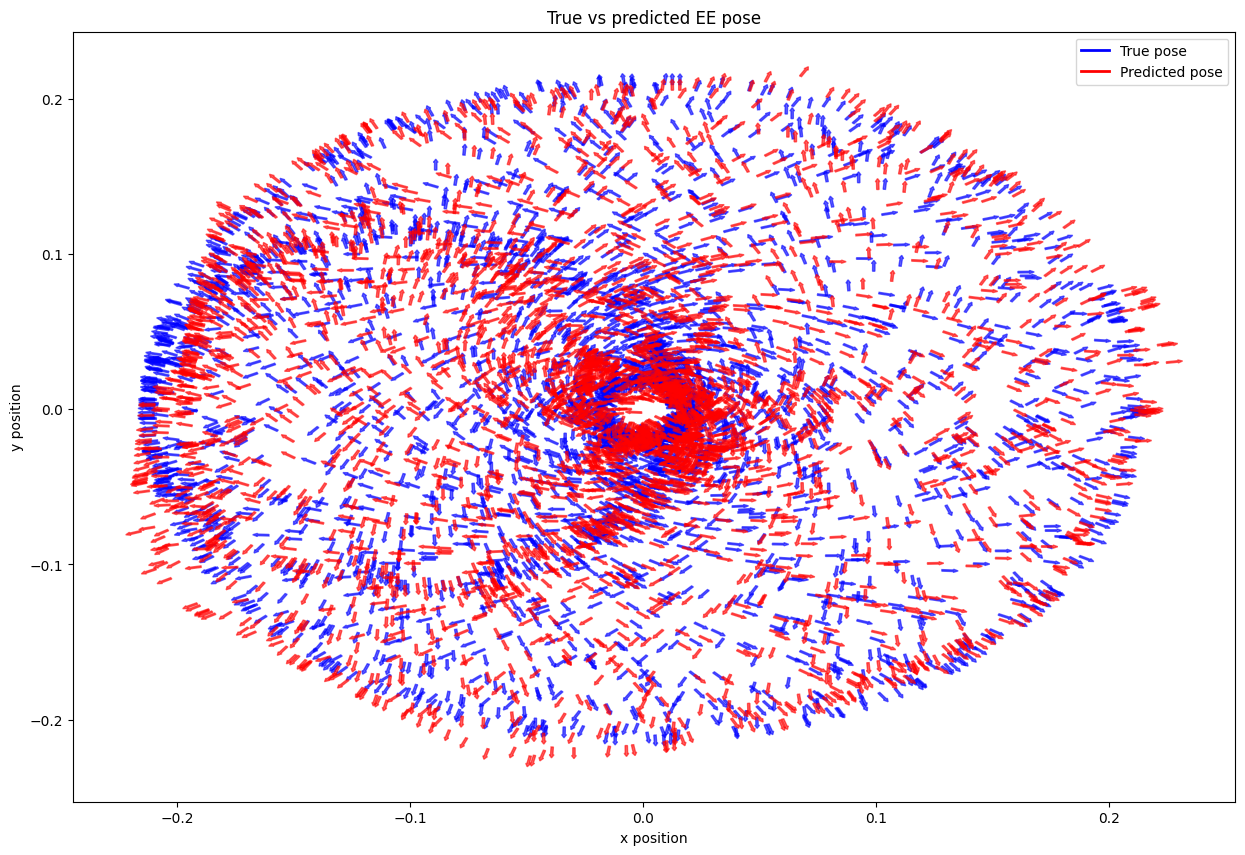

CPU times: user 12.6 s, sys: 0 ns, total: 12.6 s
Wall time: 12.6 s


In [62]:
%%time

link_length = 0.1
plt.figure(figsize=(15, 10))
for i in range(len(y_test)-30000):
    x, y = y_test[i, 0], y_test[i, 1]
    theta = y_test[i, 2]
    
    # Create an arrow for the orientation
    dx = (link_length/20) * np.cos(theta)
    dy = (link_length/20) * np.sin(theta)
    
    # Plot the true position (x, y) and the arrow for orientation
    plt.arrow(x, y, dx, dy, head_width=0.002, head_length=0.002, fc='b', ec='b', alpha=0.6)

for i in range(len(y_pred)-30000):
    x, y = y_pred[i, 0], y_pred[i, 1]
    theta = y_pred[i, 2]

    dx = (link_length/20) * np.cos(theta)
    dy = (link_length/20) * np.sin(theta)

    # Plot the predicted position (x, y) and the arrow for orientation
    plt.arrow(x, y, dx, dy, head_width=0.002, head_length=0.002, fc='r', ec='r', alpha=0.6)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='True pose'),
    Line2D([0], [0], color='red', lw=2, label='Predicted pose')
]
plt.legend(handles=legend_elements)
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('True vs predicted EE pose')
plt.show()

### Computation of the Jacobian $J$ of `r2`
The forward kinematics of the planar $2$R robot is given by
$\mathbf{p}_e = \begin{bmatrix} 
l_1c_1 + l_2c_{12} \\
l_1s_1 + l_2s_{12}
\end{bmatrix}$
where $l_1,l_2$ are the lengths of the two links, $c_1=\cos{\vartheta_1}$, $c_{12} = \cos{\vartheta_1 + \vartheta_2}$ (simmetrically $s=\sin$).

Given $\mathbf{q}=(q_1,q_2)$, the analytical Jacobian of the planar $2$R is
$$ J_r(\mathbf{q}) = \frac{\partial f_r(\mathbf{q})}{\partial\mathbf{q}} = \begin{bmatrix} \frac{\partial f_x(q_1)}{\partial q_1} & \frac{\partial f_x(q_2)}{\partial q_2} \\
\frac{\partial f_y(q_1)}{\partial q_1} & \frac{\partial f_y(q_2)}{\partial q_2} \\
\frac{\partial \phi(q_1)}{\partial q_1} & \frac{\partial \phi(q_2)}{\partial q_2}
\end{bmatrix} = \begin{bmatrix} -l_1s_1-l_2s_{12} & -l_2s_{12} \\
l_1c_1+l_2c_{12} & l_2c_{12} \\
1 & 1
\end{bmatrix} $$
where the rows $=0$ (those corresponding to $\dot{p}_z$, $\omega_x$, $\omega_y$) have been removed. If orientation is of no concern, one can compute the $2 \times 3$ Jacobian for the positional part by considering just the first $2$ rows (we are considering both position and orientation).

We can retrieve the lengths of the links in the MuJoCo XML model of `r2` (`reacher.xml`), and they are both $0.1$ units long.

We can compute the approximated Jacobian from the learned model by computing the derivative of the model's output with respect to each joint angle.

In [15]:
# Load the model
model = tf.keras.models.load_model('fk_r2.keras')

def J_r2_true(q): # True (analytical) Jacobian
    theta1, theta2 = q[0], q[1]
    l1, l2 = 0.1, 0.1
    J_11 = -l1*np.sin(theta1) -l2*np.sin(theta1 + theta2)
    J_12 = -l2*np.sin(theta1 + theta2)
    J_21 = l1*np.cos(theta1) + l2*np.cos(theta1 + theta2)
    J_22 = l2*np.cos(theta1 + theta2)
    J_31 = 1
    J_32 = 1
    return np.array([[J_11, J_12], [J_21, J_22], [J_31, J_32]])

def J_r2_model(q, model): # Jacobian learned by r2
    q = tf.Variable([q], dtype=tf.float32)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(q)
        y = model(q)
    return np.reshape(tape.jacobian(y, q), (3, 2))

q = [0.5, 0.2]
J_analytical = J_r2_true(q)
J_approx = J_r2_model(q, model)
print('Analytical Jacobian:')
print(J_analytical)
print('\nJacobian learned by the model:')
print(J_approx)
error = np.linalg.norm(J_analytical - J_approx)
print(f'\nError between learned J and analytical J: {error}')

Analytical Jacobian:
[[-0.11236432 -0.06442177]
 [ 0.16424247  0.07648422]
 [ 1.          1.        ]]

Jacobian learned by the model:
[[-0.13313727 -0.06071785]
 [ 0.18008514  0.11440843]
 [ 0.9886669   0.9670987 ]]

Error between learned J and analytical J: 0.05783947145643441


## Alternative model: (3) kernelized SVM for regression
Use just $1000$ samples because when performing grid-search my laptop cries hard.

In [79]:
# Load and split data
nsamples = 1000
env ='r2'
X_all, y_all = load_data(env, nsamples=nsamples)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.333, random_state=1891909)
y_train_x = y_train[:, 0]      # Position in x
y_train_y = y_train[:, 1]      # Position in y
y_train_theta = y_train[:, 2]  # Orientation

Loading data (1000 samples) for r2 ...
Collected 100/1000 examples
Collected 200/1000 examples
Collected 300/1000 examples
Collected 400/1000 examples
Collected 500/1000 examples
Collected 600/1000 examples
Collected 700/1000 examples
Collected 800/1000 examples
Collected 900/1000 examples
Collected 1000/1000 examples
Data loaded succesfully!

Task: Regression (learn Forward Kinematics)
Input: Joint angles
Target: EE pose


### Training and evaluation of the $3$ SVRs
Tuning the hyperparameters of these models can be made easier by performing a simple (but computationally expensive) *grid search*.

In [80]:
%%time

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# hyper-parameter search for kernelized SVM
from sklearn.model_selection import GridSearchCV

# Find the best combination between C, kernel, degree for each model
svr_models = {
    'svr_x': SVR(gamma='scale'),
    'svr_y': SVR(gamma='scale'),
    'svr_theta': SVR(gamma='scale')
}
param_grid = {
    'C': [1, 10, 100, 1000], 
    'kernel': ['linear', 'poly', 'sigmoid'],
    'degree': [1, 2, 3]
}
y_pred = []
for name, model in svr_models.items():
    print(f'Grid search for {name} model ...')
    gs = GridSearchCV(model, param_grid, cv=5, scoring='r2')
    if name == 'svr_x':
        gs.fit(X_train, y_train_x)
    elif name == 'svr_y':
        gs.fit(X_train, y_train_y)
    elif name == 'svr_theta':
        gs.fit(X_train, y_train_theta)
    print(f'Best {name} params: {gs.best_params_}')
    print(f'Best {name} R2-score: {gs.best_score_}\n')
    y_pred.append(gs.predict(X_test))

Grid search for svr_x model ...
Best svr_x params: {'C': 10, 'degree': 2, 'kernel': 'poly'}
Best svr_x R2-score: 0.2384767895830556

Grid search for svr_y model ...
Best svr_y params: {'C': 100, 'degree': 3, 'kernel': 'poly'}
Best svr_y R2-score: 0.15576599190346024

Grid search for svr_theta model ...
Best svr_theta params: {'C': 1, 'degree': 1, 'kernel': 'poly'}
Best svr_theta R2-score: 0.9996930554104543

CPU times: user 4min 36s, sys: 0 ns, total: 4min 36s
Wall time: 4min 36s


### Plot results for SVRs

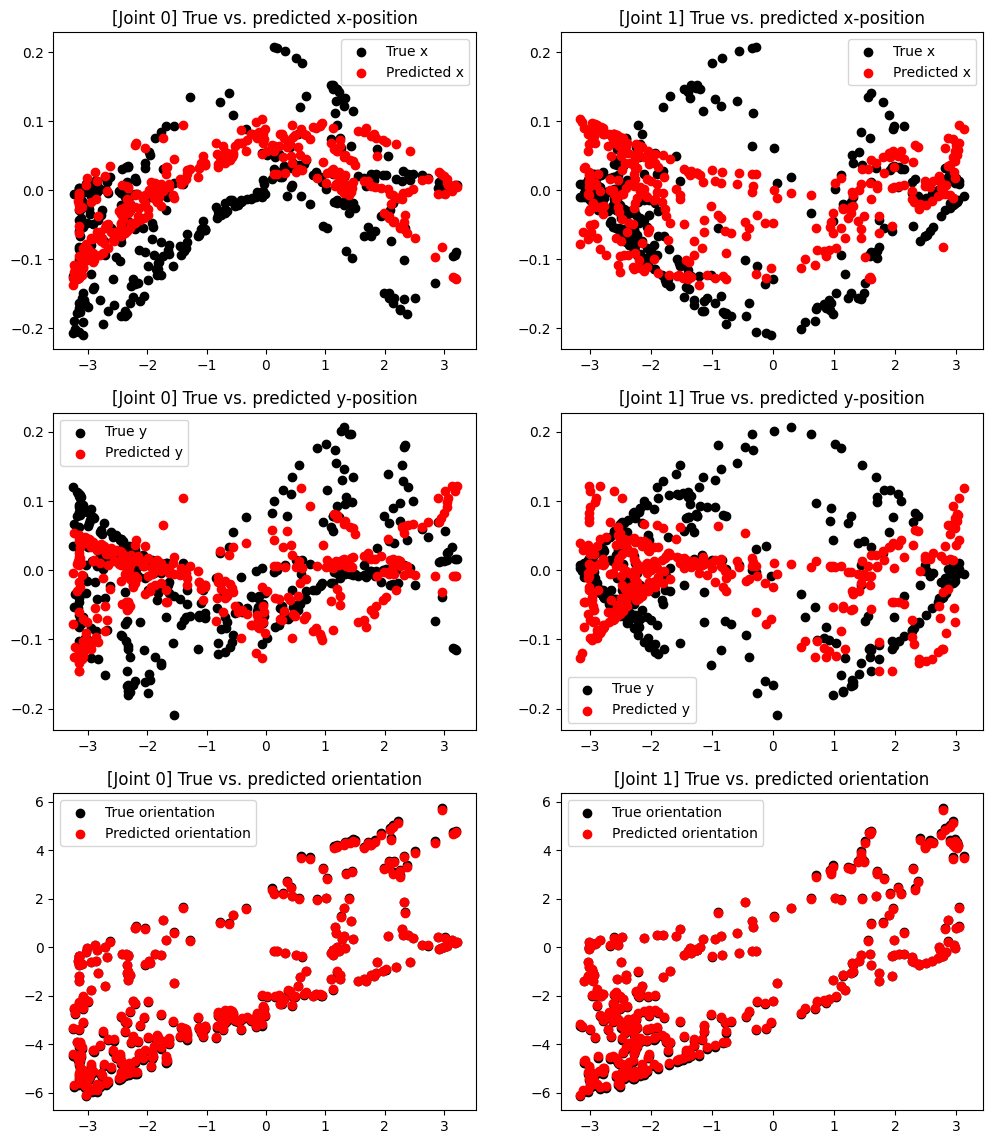

In [81]:
plt.figure(figsize=(12,14))

plt.subplot(3,2,1)
plt.scatter(X_test[:, 0], y_test[:, 0], color='black', label='True x')
plt.scatter(X_test[:, 0], y_pred[0], color='red', label='Predicted x')
plt.title('[Joint 0] True vs. predicted x-position')
plt.legend()

plt.subplot(3,2,2)
plt.scatter(X_test[:, 1], y_test[:, 0], color='black', label='True x')
plt.scatter(X_test[:, 1], y_pred[0], color='red', label='Predicted x')
plt.title('[Joint 1] True vs. predicted x-position')
plt.legend()

plt.subplot(3,2,3)
plt.scatter(X_test[:, 0], y_test[:, 1], color='black', label='True y')
plt.scatter(X_test[:, 0], y_pred[1], color='red', label='Predicted y')
plt.title('[Joint 0] True vs. predicted y-position')
plt.legend()

plt.subplot(3,2,4)
plt.scatter(X_test[:, 1], y_test[:, 1], color='black', label='True y')
plt.scatter(X_test[:, 1], y_pred[1], color='red', label='Predicted y')
plt.title('[Joint 1] True vs. predicted y-position')
plt.legend()

plt.subplot(3,2,5)
plt.scatter(X_test[:, 0], y_test[:, 2], color='black', label='True orientation')
plt.scatter(X_test[:, 0], y_pred[2], color='red', label='Predicted orientation')
plt.title('[Joint 0] True vs. predicted orientation')
plt.legend()

plt.subplot(3,2,6)
plt.scatter(X_test[:, 1], y_test[:, 2], color='black', label='True orientation')
plt.scatter(X_test[:, 1], y_pred[2], color='red', label='Predicted orientation')
plt.title('[Joint 1] True vs. predicted orientation')
plt.legend()

## Planar 3R robot arm
Let us move to the next robot model, i.e. the $3$R planar arm:
- $n=3=\#\text{joints}=\#\text{DOFs}$
- $m=3=\text{size of the task space}$

By learning the forward kinematics for such a robot, we still can expect to find a vector
$$ \mathbf{r}_e=\begin{bmatrix} \mathbf{p}_e \\ \boldsymbol{\phi}_e \end{bmatrix} = \begin{bmatrix} x_e \\ y_e \\ \vartheta \end{bmatrix} $$

Though, this time the robot has $3$ revolute joints, and therefore $\mathbf{r} = f_\mathbf{r}(\mathbf{q}) = f_\mathbf{r}(q_1, q_2, q_3) \implies$ the number of features increases to $3$.

### Load data for training

In [63]:
# Load data
env = 'r3'
nsamples = 100000
X_all, y_all = load_data(env, nsamples=nsamples)

# Print data info
ninput = X_all.shape[1]
nsamples = X_all.shape[0]
noutput = y_all.shape[1]
print('\nPrinting data info ...')
print(f'Dataset: {env}')
print(f'Input shape: {X_all.shape}')
print(f'Output shape: {y_all.shape}')
print(f'Number of samples: {nsamples}')
print(f'Number of attributes/features: {ninput}')

# Split data
print('\nSplitting data ...')
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.333, random_state=1891909)
print(f'Training set size: {len(X_train)}')
print(f'Test set size: {len(X_test)}')

# Show some examples
print('\nDisplaying the first 5 examples ...')
for i in range(5):
    print(f'Example {i+1}')
    print(f'Joint angles (X): {X_all[i]}')
    print(f'End-Effector pose (Y): {y_all[i]}\n')

Loading data (100000 samples) for r3 ...
Collected 10000/100000 examples
Collected 20000/100000 examples
Collected 30000/100000 examples
Collected 40000/100000 examples
Collected 50000/100000 examples
Collected 60000/100000 examples
Collected 70000/100000 examples
Collected 80000/100000 examples
Collected 90000/100000 examples
Collected 100000/100000 examples
Data loaded succesfully!

Task: Regression (learn Forward Kinematics)
Input: Joint angles
Target: EE pose

Printing data info ...
Dataset: r3
Input shape: (100000, 3)
Output shape: (100000, 3)
Number of samples: 100000
Number of attributes/features: 3

Splitting data ...
Training set size: 66700
Test set size: 33300

Displaying the first 5 examples ...
Example 1
Joint angles (X): [-0.00966934 -0.08418354  0.0569389 ]
End-Effector pose (Y): [ 0.30948042 -0.01439636 -0.03690965]

Example 2
Joint angles (X): [-0.0100018  -0.10001607  0.06592021]
End-Effector pose (Y): [ 0.30928328 -0.0168313  -0.04410329]

Example 3
Joint angles (X):

### Create and train the model

Training the model...
Epoch 1/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.5656 - val_loss: 0.3306
Epoch 2/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3192 - val_loss: 0.2344
Epoch 3/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2457 - val_loss: 0.1921
Epoch 4/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2124 - val_loss: 0.1675
Epoch 5/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1948 - val_loss: 0.2110
Epoch 6/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2258 - val_loss: 0.1909
Epoch 7/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2019 - val_loss: 0.1741
Epoch 8/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1888 - val_loss: 0.1625
Epoch 9/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1781 - val_loss: 0.1556
Epoch 10/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1723 - val_loss: 0.1409
Epoch 11/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1627 - val_loss: 0.1443
Epoch 12

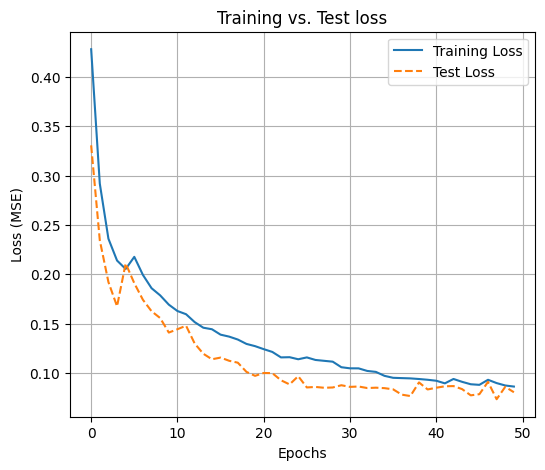

CPU times: user 8min 2s, sys: 1min 4s, total: 9min 7s
Wall time: 4min 26s


In [48]:
%%time

# Define optimizer and loss function
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

tf.keras.utils.set_random_seed(seed)

if os.path.exists('fk_r3.keras'):
    model = tf.keras.models.load_model('fk_r3.keras')
    print("Model loaded!")
else:
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(ninput,)), # 3 input units (3 joint angles)
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(noutput) # 3 output units
    ])
    model.compile(loss=loss_fn, optimizer=opt)
    print("Training the model...")
    nepochs = 50
    batch_size = 32
    h = model.fit(X_train, y_train, epochs=nepochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
    print(f"Final training loss: {h.history['loss'][-1]}")
    print(f'Final test loss: {h.history['val_loss'][-1]}')
    model.save('fk_r3.keras')

    # Plot training vs. test loss
    plt.figure(figsize=(6, 5))
    plt.plot(h.history['loss'], label='Training Loss')
    plt.plot(h.history['val_loss'], label='Test Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training vs. Test loss')
    plt.legend()
    plt.grid(True)
    plt.show()

### Evaluation
Again, the plot is based on only roughly $3000$ samples.

1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Mean Absolute Error = 0.0425
R2-Score = 0.9762


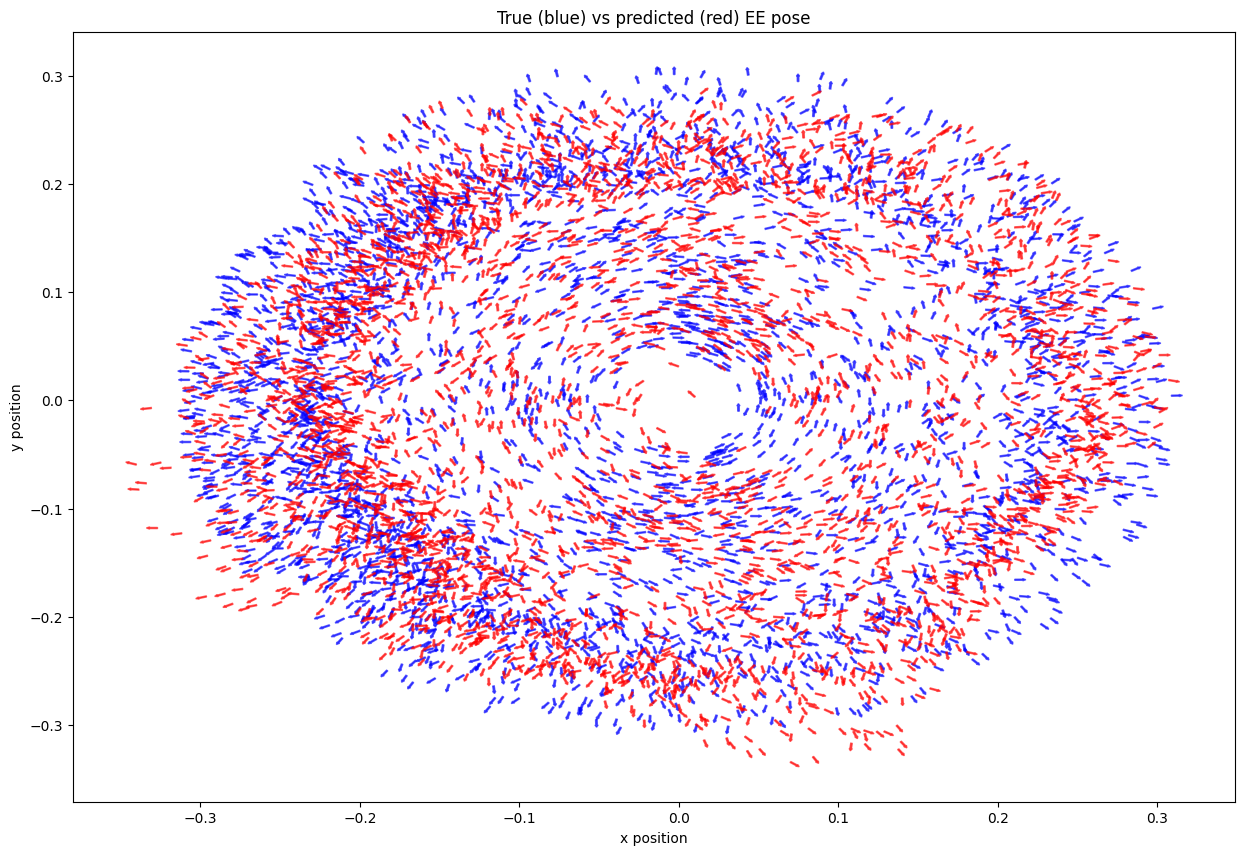

In [49]:
# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error = {mae:.4f}')
print(f'R2-Score = {r2:.4f}')

# Plot results
link_length = 0.1
plt.figure(figsize=(15, 10))
for i in range(len(y_test)-30000):
    x, y = y_test[i, 0], y_test[i, 1]
    theta = y_test[i, 2]
    
    # Create an arrow for the orientation
    dx = (link_length/20) * np.cos(theta)
    dy = (link_length/20) * np.sin(theta)
    
    # Plot the true position (x, y) and the arrow for orientation
    plt.arrow(x, y, dx, dy, head_width=0.002, head_length=0.002, fc='b', ec='b', alpha=0.6)

for i in range(len(y_pred)-30000):
    x, y = y_pred[i, 0], y_pred[i, 1]
    theta = y_pred[i, 2]

    dx = (link_length/20) * np.cos(theta)
    dy = (link_length/20) * np.sin(theta)

    # Plot the predicted position (x, y) and the arrow for orientation
    plt.arrow(x, y, dx, dy, head_width=0.002, head_length=0.002, fc='r', ec='r', alpha=0.6)

plt.xlabel('x position')
plt.ylabel('y position')
plt.title('True (blue) vs predicted (red) EE pose')
plt.show()

### Jacobian of `r3`

In [64]:
# Load the model
model = tf.keras.models.load_model('fk_r3.keras')

def J_r3_true(q): # True (analytical) Jacobian
    theta1, theta2, theta3 = q[0], q[1], q[2]
    l1, l2, l3 = 0.1, 0.1, 0.1
    s1, s12, s123 = np.sin(theta1), np.sin(theta1 + theta2), np.sin(theta1 + theta2 + theta3)
    c1, c12, c123 = np.cos(theta1), np.cos(theta1 + theta2), np.cos(theta1 + theta2 + theta3)
    J_11 = -l1*s1 - l2*s12 - l3*s123
    J_12 = -l2*s12 - l3*s123
    J_13 = -l3*s123
    J_21 = l1*c1 + l2*c12 + l3*c123
    J_22 = l2*c12 + l3*c123
    J_23 = l3*c123
    J_31 = 1
    J_32 = 1
    J_33 = 1
    return np.array([[J_11, J_12, J_13], [J_21, J_22, J_23], [J_31, J_32, J_33]])

def J_r3_model(q, model): # Jacobian learned by r3
    q = tf.Variable([q], dtype=tf.float32)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(q)
        y = model(q)
    return np.reshape(tape.jacobian(y, q), (3, 3))

q = [0.5, 0.2, 0.3]
J_analytical = J_r3_true(q)
J_approx = J_r3_model(q, model)
print('Analytical Jacobian:')
print(J_analytical)
print('\nJacobian learned by the model:')
print(J_approx)
error = np.linalg.norm(J_analytical - J_approx)
print(f'\nError between learned J and analytical J: {error}')

Analytical Jacobian:
[[-0.19651142 -0.14856887 -0.0841471 ]
 [ 0.21827271  0.13051445  0.05403023]
 [ 1.          1.          1.        ]]

Jacobian learned by the model:
[[-0.14897193  0.00708798 -0.1224689 ]
 [ 0.2843559   0.19073725  0.00479622]
 [ 0.9807746   1.1225857   0.98393387]]

Error between learned J and analytical J: 0.23244431357350906


## Spatial 5R robot arm
The final case involves a robot with $5$ revolute joints which operates in a $3$D space, meaning $m=6$ and $n=5$.

The vector $\mathbf{r}_e$ describing the pose of the end-effector becomes
$$ \mathbf{r}_e = \begin{bmatrix} \mathbf{p}_e \\ \boldsymbol{\phi}_e \end{bmatrix} = \begin{bmatrix} x_e & y_e & z_e & \psi & \vartheta & \psi \end{bmatrix}^T $$
as its position is now expressed in a $3$D space ($\implies 3$ coordinates $\begin{bmatrix} x_e & y_e & z_e \end{bmatrix}^T$) and its orientation is represented using the Euler angles $(\psi, \vartheta, \varphi)$.

Therefore, the regression task now sees as the input $n=5$ joint angles, and as the output $m=6$ values representing the pose of the end-effector.

### Preparing data for training

In [65]:
# Load data
env = 'r5'
nsamples = 100000
X_all, y_all = load_data(env, nsamples=nsamples)

# Print data info
ninput = X_all.shape[1]
nsamples = X_all.shape[0]
noutput = y_all.shape[1]
print('\nPrinting data info ...')
print(f'Dataset: {env}')
print(f'Input shape: {X_all.shape}') # 
print(f'Output shape: {y_all.shape}')
print(f'Number of samples: {nsamples}')
print(f'Number of attributes/features: {ninput}')

# Split data
print('\nSplitting data ...')
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.333, random_state=1891909)
print(f'Training set size: {len(X_train)}')
print(f'Test set size: {len(X_test)}')

# Show some examples
print('\nDisplaying the first 5 examples ...')
for i in range(5):
    print(f'Example {i+1}')
    print(f'Joint angles (X): {X_all[i]}')
    print(f'End-Effector pose (Y): {y_all[i]}\n')

Loading data (100000 samples) for r5 ...
Collected 10000/100000 examples
Collected 20000/100000 examples
Collected 30000/100000 examples
Collected 40000/100000 examples
Collected 50000/100000 examples
Collected 60000/100000 examples
Collected 70000/100000 examples
Collected 80000/100000 examples
Collected 90000/100000 examples
Collected 100000/100000 examples
Data loaded succesfully!

Task: Regression (learn Forward Kinematics)
Input: Joint angles
Target: EE pose

Printing data info ...
Dataset: r5
Input shape: (100000, 5)
Output shape: (100000, 6)
Number of samples: 100000
Number of attributes/features: 5

Splitting data ...
Training set size: 66700
Test set size: 33300

Displaying the first 5 examples ...
Example 1
Joint angles (X): [-0.00274897 -0.02365944  0.01626468  0.00512214  0.03137823]
End-Effector pose (Y): [-0.00395837 -0.00375234  0.58990661 -0.00267523 -0.00235686  0.03135888]

Example 2
Joint angles (X): [-0.03116074 -0.08882913  0.04731242  0.02282846  0.0977448 ]
End-E

### Training

Training the model...
Epoch 1/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.4803 - val_loss: 0.2785
Epoch 2/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2481 - val_loss: 0.2050
Epoch 3/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.2008 - val_loss: 0.1732
Epoch 4/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1775 - val_loss: 0.1517
Epoch 5/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1635 - val_loss: 0.1460
Epoch 6/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1522 - val_loss: 0.1505
Epoch 7/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1456 - val_loss: 0.1395
Epoch 8/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1398 - val_loss: 0.1369
Epoch 9/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1327 - val_loss: 0.1338
Epoch 10/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1286 - val_loss: 0.1295
Epoch 11/50
2085/2085 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1245 - val_loss: 0.1317
Epoch 12

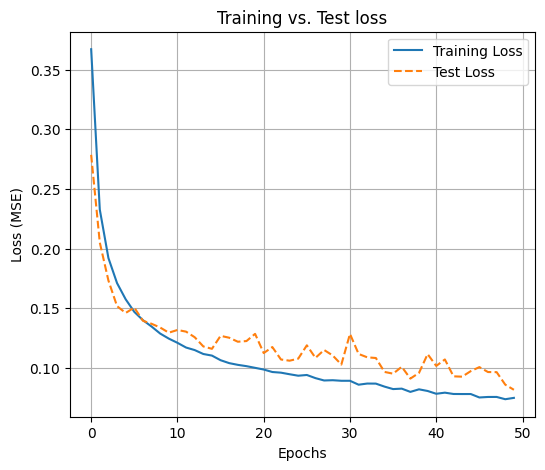

CPU times: user 8min 18s, sys: 56 s, total: 9min 14s
Wall time: 4min 16s


In [73]:
%%time

# Define optimizer and loss function
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

tf.keras.utils.set_random_seed(seed)

if os.path.exists('fk_r5.keras'):
    model = tf.keras.models.load_model('fk_r5.keras')
    print("Model loaded!")
else:
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(ninput,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(noutput)
    ])
    model.compile(loss=loss_fn, optimizer=opt)
    print("Training the model...")
    nepochs = 50
    batch_size = 32
    h = model.fit(X_train, y_train, epochs=nepochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
    print(f"Final training loss: {h.history['loss'][-1]}")
    print(f"Final test loss: {h.history['val_loss'][-1]}")
    model.save('fk_r5.keras')

    # Plot training loss
    plt.figure(figsize=(6, 5))
    plt.plot(h.history['loss'], label='Training Loss')
    plt.plot(h.history['val_loss'], label='Test Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training vs. Test loss')
    plt.legend()
    plt.grid(True)
    plt.show()

### Evaluation
The $3$D plot is heavier to be computed and messy to be visualized; in this regard, only a few of all true and predicted samples are plotted.

1041/1041 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Mean Absolute Error = 0.0845
R2-Score = 0.9381


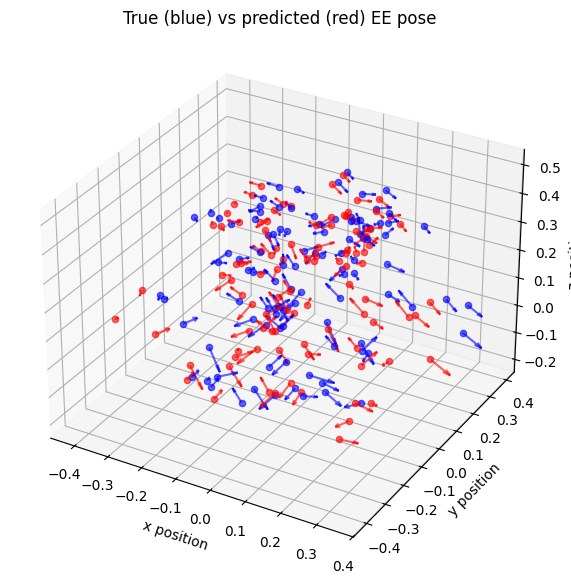

In [72]:
# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error = {mae:.4f}')
print(f'R2-Score = {r2:.4f}')

# Plot results (just a few samples)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(y_test)-33200):
    x, y, z = y_test[i, 0], y_test[i, 1], y_test[i, 2]
    yaw, pitch, roll = y_test[i, 3], y_test[i, 4], y_test[i, 5]
    ax.scatter(x, y, z, color='b', alpha=0.6) # Plot the true position
    ax.quiver(x, y, z, yaw, pitch, roll, length=0.02, color='b', alpha=0.6) # Plot an arrow representing orientation at the true position

for i in range(len(y_pred)-33200):
    x, y, z = y_pred[i, 0], y_pred[i, 1], y_pred[i, 2]
    yaw, pitch, roll = y_pred[i, 3], y_pred[i, 4], y_pred[i, 5]
    ax.scatter(x, y, z, color='r', alpha=0.6) # Plot the true position
    ax.quiver(x, y, z, yaw, pitch, roll, length=0.02, color='r', alpha=0.6) # Plot an arrow representing orientation at the true position

ax.set_xlabel('x position')
ax.set_ylabel('y position')
ax.set_zlabel('z position')
ax.set_title('True (blue) vs predicted (red) EE pose')
plt.show()

## Hyper-parameter search
It is of interest to study the performance of the above models in situations of different optimizers and learning rates. The number of epochs is limited to $10$ for computation reasons (I have no GPU).

In [95]:
%%time

print('Hyper-parameter search ...')
print('Optimizers: SGD, RMSprop, Adam')
print('Learning rates: 0.001, 0.005, 0.01')
envs = ['r2', 'r3', 'r5']
opts = {
        'SGD': tf.keras.optimizers.SGD,
        'RMSprop': tf.keras.optimizers.RMSprop,
        'Adam': tf.keras.optimizers.Adam
}
lrates = [0.001, 0.005, 0.01]
hs = {env: [] for env in envs}
nepochs=10
batch_size=32
nsamples=10000
for env in envs:
    X_all, y_all = load_data(env, nsamples=nsamples)
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.333, random_state=1891909)
    ninput = X_all.shape[1]
    nsamples = X_all.shape[0]
    noutput = y_all.shape[1]
    for lrate in lrates:
        for name, optimizer in opts.items():
            print(f'\n########## (Environment, Optimizer, Learning rate) = ({env}, {name}, {lrate}) ##########')
            # Assert reproducibility
            tf.keras.utils.set_random_seed(seed)
            
            # Create the model
            if env == 'r2':
                model = tf.keras.Sequential([
                    tf.keras.layers.Input(shape=(ninput,)),
                    tf.keras.layers.Dense(64, activation='relu'),
                    tf.keras.layers.Dense(64, activation='relu'),
                    tf.keras.layers.Dense(32, activation='relu'),
                    tf.keras.layers.Dense(noutput)
                ])
            elif env == 'r3':
                model = tf.keras.Sequential([
                    tf.keras.layers.Input(shape=(ninput,)),
                    tf.keras.layers.Dense(64, activation='relu'),
                    tf.keras.layers.Dense(64, activation='relu'),
                    tf.keras.layers.Dense(32, activation='relu'),
                    tf.keras.layers.Dense(noutput)
                ])
            elif env == 'r5':
                model = tf.keras.Sequential([
                    tf.keras.layers.Input(shape=(ninput,)),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dense(64, activation='relu'),
                    tf.keras.layers.Dense(32, activation='relu'),
                    tf.keras.layers.Dense(noutput)
                ])
            opt = optimizer(learning_rate=lrate)
            model.compile(loss=loss_fn, optimizer=opt)
    
            # Train the model
            h = model.fit(X_train, y_train, epochs=nepochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
            hs[env].append({(name, lrate): h})

Hyper-parameter search ...
Optimizers: SGD, RMSprop, Adam
Learning rates: 0.001, 0.005, 0.01
Loading data (10000 samples) for r2 ...
Collected 1000/10000 examples
Collected 2000/10000 examples
Collected 3000/10000 examples
Collected 4000/10000 examples
Collected 5000/10000 examples
Collected 6000/10000 examples
Collected 7000/10000 examples
Collected 8000/10000 examples
Collected 9000/10000 examples
Collected 10000/10000 examples
Data loaded succesfully!

Task: Regression (learn Forward Kinematics)
Input: Joint angles
Target: EE pose

########## (Environment, Optimizer, Learning rate) = (r2, SGD, 0.001) ##########
Epoch 1/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.5523 - val_loss: 1.5298
Epoch 2/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2075 - val_loss: 0.4188
Epoch 3/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2830 - val_loss: 0.1188
Epoch 4/10
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0713 - val_loss: 0.0802
Epoch 5/10
209/209 ━━━━━━━━━━━━━━━

### Comparison among optimizers for each learning rate

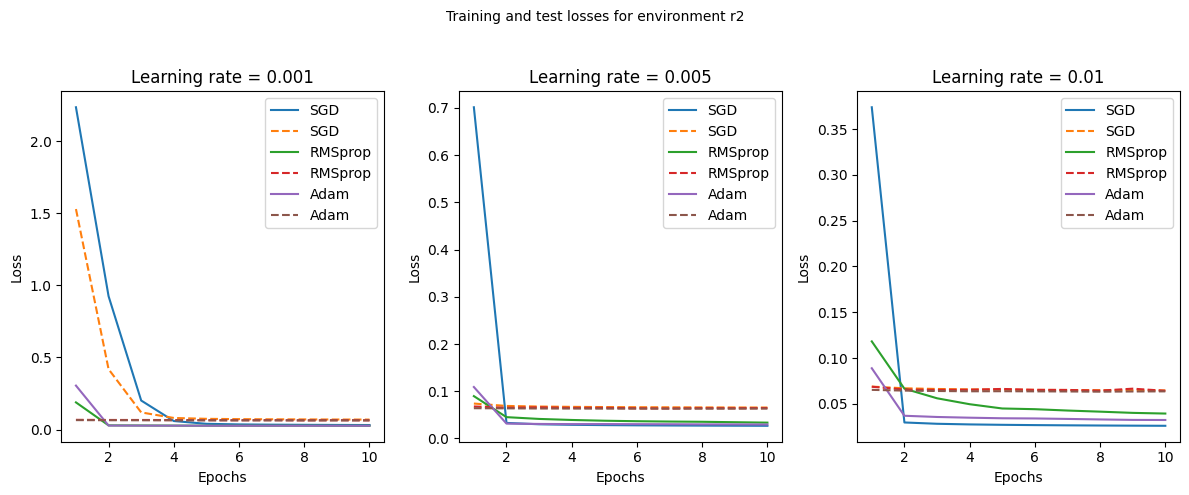

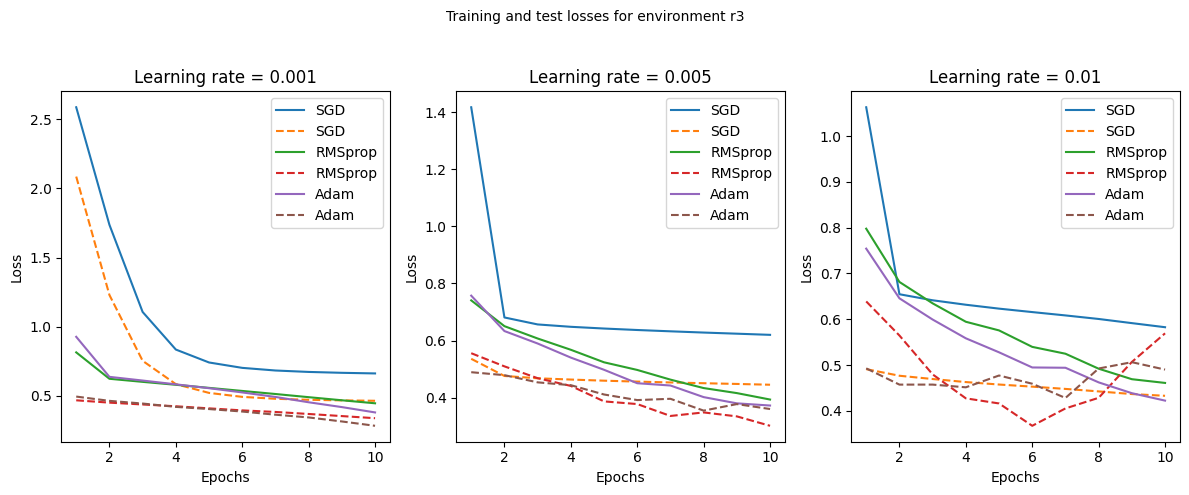

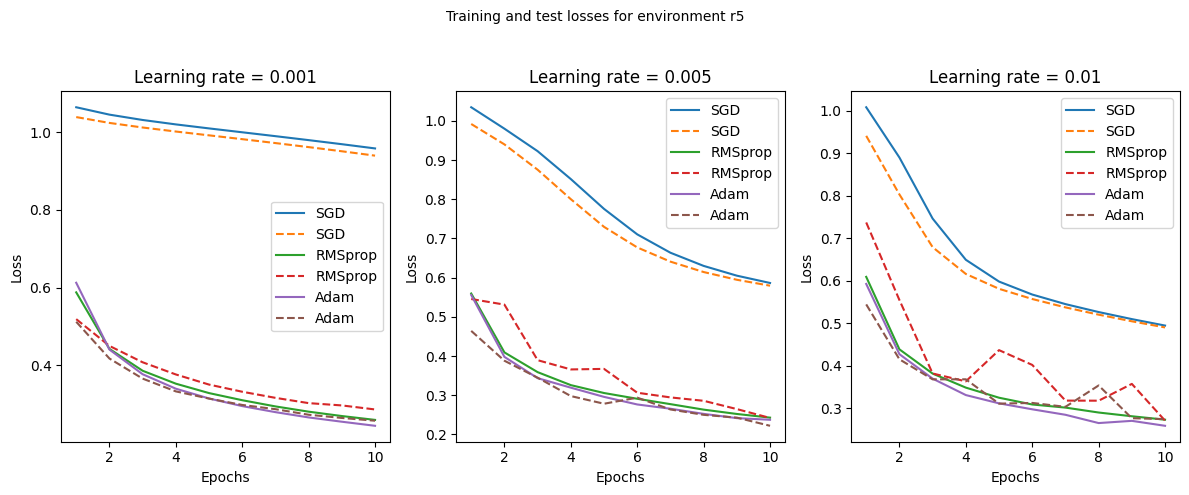

In [100]:
# Plot training losses for each learning rate with different optimizers
for env in envs:
    fig, axes = plt.subplots(1, len(lrates), figsize=(12, 5))
    fig.suptitle(f'Training and test losses for environment {env}', fontsize=10)
    for i, lrate in enumerate(lrates):
        ax = axes[i]
        for opt_name in opts:
            history = next(h[(opt_name, lrate)] for h in hs[env] if (opt_name, lrate) in h)
            ax.plot(range(1, nepochs + 1), history.history['loss'], label=opt_name)
            ax.plot(range(1, nepochs + 1), history.history['val_loss'], label=opt_name, linestyle='--')
        ax.set_title(f'Learning rate = {lrate}')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()